# Logistic Regression: Training stability

In [1]:
import sys
sys.path.insert(0, './code/')

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import util
import p01_lr

In [3]:
import os
os.getcwd()

'/Users/inespancorbo/CS229/ps2'

Text(0.5, 1.0, 'Dataset A')

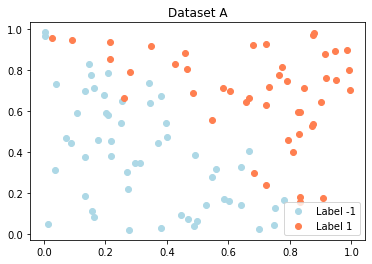

In [4]:
xA, yA = util.load_csv('./data/ds1_a.csv', add_intercept=False)
plt.scatter(xA[yA==-1,0], xA[yA==-1,1], c='lightblue', label='Label -1')
plt.scatter(xA[yA==1,0], xA[yA==1,1], c='coral', label='Label 1')
plt.legend()
plt.title("Dataset A")

Text(0.5, 1.0, 'Dataset B')

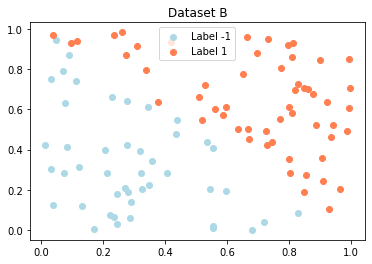

In [5]:
xB, yB = util.load_csv('./data/ds1_b.csv', add_intercept=False)
plt.scatter(xB[yB==-1,0], xB[yB==-1,1], c='lightblue', label='Label -1')
plt.scatter(xB[yB==1,0], xB[yB==1,1], c='coral', label='Label 1')
plt.legend()
plt.title("Dataset B")

In [6]:
p01_lr.main()

==== Training model on data set A ====
Finished 10000 iterations
Finished 20000 iterations
Finished 30000 iterations
Finished 40000 iterations
Finished 50000 iterations
Finished 60000 iterations
Finished 70000 iterations
Finished 80000 iterations
Finished 90000 iterations
Finished 100000 iterations
Finished 110000 iterations
Finished 120000 iterations
Finished 130000 iterations
Finished 140000 iterations
Finished 150000 iterations
Finished 160000 iterations
Finished 170000 iterations
Finished 180000 iterations
Finished 190000 iterations
Finished 200000 iterations
Finished 210000 iterations
Finished 220000 iterations
Finished 230000 iterations
Finished 240000 iterations
Finished 250000 iterations
Finished 260000 iterations
Finished 270000 iterations
Converged in 278192 iterations

==== Training model on data set B ====
Finished 10000 iterations
Finished 20000 iterations
Finished 30000 iterations
Finished 40000 iterations
Finished 50000 iterations
Finished 60000 iterations
Finished 70000

KeyboardInterrupt: 

## (a)

__What is the most notable difference in training the logistic regression model on datasets A and B?__

It seems like we converge with dataset A (with a tolerance of $10^{-15}$, and a stopping condition of the norm of the parameter vector less than $10^{-15}$). It does not seem like logistic regression converges for dataset B.


## (b)

__Investigate why the training procedure behaves unexpectedly on dataset B, but not on A. Provide hard evidence (in the form of math, code, plots, etc.) to corroborate your hypothesis for the misbehavior. Remember, you should address why your explanation does not apply to A. Hint: The issue is not a numerical rounding or over/underflow error.__

We can see the problem in the plot of the two datatsets. Dataset B is linearly separable. In general, linear separability is a good thing for a binary classification problem. However, it creates a pathology for unregularized logistic regression. You can see this by recalling that the decision boundary is the set $\{x: \theta^Tx=0\}$ (assuming probability cut-off of $50\%$) and this set is unchanged if we multiply $\theta$ by some constant $c$. However, the scale does affect the likelihood function by causing the logistic function to be more steep. See illustration below.

In [ ]:
import pandas as pd
df = pd.DataFrame(np.arange(-1,1,0.05), columns=['x'])
constants = [1, 5, 10, 20, 30, 40, 50, 80, 100]
for c in constants:
    df[str(c)] = df['x'].apply(logistic, c=c)
df = df.set_index('x')
#df.head()
df.plot()

Imagine that you have a perfectly separated set of points, with the separation ocurring at zero in the plot above (*). 

Since for any $c$, the boundary set does not change, any of these logistic functions is valid. Which logistic function, dependent on $\theta$, to choose? Let us examine this from a (more) formal mathematical perspective.

Let $S(c,z)=\frac{1}{1+e^{-cz}}$.

Note that:

$\displaystyle \lim_{c \to \infty}S(c,z)=0$ for $z <0$

$\displaystyle \lim_{c \to \infty}S(c,z)=1$ for $z >0$

Given the notation used above, the hyperplane $z=\theta^Tx=0$ separates the space into the sets $\{x: z <0\}$ and $\{x: z>0\}$ and because of the perfect separation, all $x$ such that $z<0$ will be from class $0$, and all $x$ such that $z>0$ will be from class $1$ (given what we assumed in (*)).

Let us assume our data is centered so we can ignore the intercept as it is zero. The function we are maximizing in logistic regression is

$$L(c)= \sum_i y_i \log(S(c, z_i)) + (1 - y_i) \log(1 - S(c, z_i))$$

This summation has two types of terms.  Terms in which $y_i = 0$, look like $\log(1 - S(c, z_i))$, and because of the perfect separation we know that for these terms $z_i < 0$.  By the first limit above, this means that

$$ \lim_{c \rightarrow \infty} S(c, z_i) = 0$$

for every $z_i$ associated with a $y_i=0$.  Then, after applying the logarithm, we get:

$$ \lim_{c \rightarrow \infty} \log(1 - S(c, z_i)) = 0$$

You can easily use the same ideas to show that for the other type of terms

$$ \lim_{c \rightarrow \infty} \log(S(c, z_i)) = 0$$

So no matter what $c$ is, you can always drive the objective function upwards by increasing $c$ towards infinity.  So the objective function has no maximum, and attempting to find one iteratively will just increase $c$ forever.

It's worth noting where we used the separation.  If we could not find a separator then we could not partition the terms into two groups, we would instead have four types

- Terms with $y_i = 0$ and $z_i > 0$
- Terms with $y_i = 0$ and $z_i < 0$
- Terms with $y_i = 1$ and $z_i > 0$
- Terms with $y_i = 1$ and $z_i < 0$

In this case, when $c$ gets very large the terms with $y_i = 1$ and $z_i < 0$ will drive to negative infinity. When $c$ gets very negative, the $y_i = 0$ and $z_i < 0$ will do the same.  So somewhere in the middle, there must be a maximum.


So summarizing, when the training data is linearly separable, two "bad" things happen:
1. $||\theta|| = \infty$
2. There are infinte number of MLEs

One way to avoid this is to incorporate a prior on $\theta$ in the form of a zero-mean Gaussian with covariance $\frac{1}{2\lambda}I$, 

$$\theta \sim N(0,\frac{1}{2\lambda}I)$$

and seek the MAP (maximum a posteriori) estimate. This is essentially smoothing, since large $\theta$ values will be penalized more. We seek the maximum a posteriori (MAP) estimator.

Quick refresher on MAP estimation:

MLE is great, but it is not the only way to estimate parameters! The paradigm of MAP is that we should choose the value for our parameters that is the most likely given the data. At first blush this might seem the same as MLE; however, remember that MLE chooses the value of parameters that makes the data most likely. The former implies conditioning, the latter does not. 

One of the disadvantages of MLE is that it best explains data we have seen and makes no attempt to generalize to unseen data. In MAP, we incorporate prior belief about our parameters, and then we update our posterior belief of the parameters based on the data we have seen.

Formally, for i.i.d random variables $X_1, X_2, ..., X_n:$

$$\theta_{MLE}= \text{arg max}_{\theta} \displaystyle L(\theta)$$
where $L(\theta)=p(\underline{x};\theta)$

$$\theta_{MAP}=\text{arg max}_{\theta}p(\theta|\underline{x})$$ 

$$=\text{arg max}_{\theta}\frac{p(\underline{x}|\theta)p(\theta)}{p(\underline{x})} \text{by Bayes Theorem}$$

$$=\text{arg max}_{\theta}\frac{\displaystyle \prod_{i=1}^{N}p(x^{(i)}|\theta)p(\theta)}{p(\underline x)} \text{Since the samples are i.i.d}$$

$$=\text{arg max}_{\theta}\displaystyle \prod_{i=1}^{N}p(x^{(i)}|\theta)p(\theta) \text{Since the denominator is a constant in the opt problem}$$

It is more convenient to find the arg max of the log of the MAP function, which gives us the final form for MAP estimation of parameters.

$$\text{arg max}_{\theta}\text{log}p(\theta)+\displaystyle \sum_{i=1}^{N}\text{log}p(x^{(i)}|\theta)$$

Using Bayesian terminology, the MAP estimate is the mode of the “posterior” distribution for $\theta$. If you look at this equation side by side with the MLE equation you will notice that MAP is the arg max of the exact same function plus a term for the log of the prior.

Now, back to the problem, assuming, 

$$\theta \sim N(0,\frac{1}{2\lambda}I)$$

we have that,

$$\text{arg max}_{\theta}\text{log}p(\theta)+\displaystyle \sum_{i=1}^{N}\text{log}p(x^{(i)}|\theta)$$

$$=\text{arg max}_{\theta} -\lambda ||\theta||^2+\sum_{i=1}^{N}\text{log}p(x^{(i)}|\theta)$$


## (c)

__For each of these possible modifications, state whether or not it would lead to the provided training algorithm converging on datasets such as B. Justify your answers.__

1. Using a different constant learning rate.

No. $L(\theta)$ can still be arbitrarily large.

2. Decreasing the learning rate over time (e.g. scaling the initial learning rate by $1/t^2$, where $t$ is the number of gradient descent iterations thus far).

Maybe, if the learning rate is small enough, the change in the parameter might be small enough to stop training. This is a big maybe.

3. Linear scaling of the input features.

No. The dataset will still be linearly separable.

4. Adding a regularization term $||\theta||^2$ to the loss function.

Yes. As seen above. 

5. Adding zero-mean Gaussian noise to the training data or labels.

Yes. This could make the dataset not linearly separable, and easier to reach the global minimum.


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

def fun(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=2020)
    #x_train = preprocessing.scale(x_train)
    #x_test = preprocessing.scale(x_test)
    model = LogisticRegression(C=2.0, solver='lbfgs')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return model.score(x_test, y_test)


print(round(fun(xA, yA),2))
print(round(fun(xB, yB),2))

0.85
0.91


# Model Calibration

>"We desire that the estimated class probabilities are reflective of the true underlying probability of the sample. That is, the predicted class probability (or probability-like value) needs to be well-calibrated. To be well-calibrated, the probabilities must effectively reflect the true likelihood of the event of interest."

Page 249, __Applied Predictive Modeling,__ 2013

__Why it happens?__

Our models can output inaccurate probabilities for a variety of reasons:

1. Flawed model assumptions (e.g. independence in a Naive Bayes Model)
2. Hidden features not available at training time
3. Deficiencies in the learning algorithm.

In terms of learning algorithms, as noted in *Niculescu-Mizil et al*:

1. Naive Bayes tends to push probabilities toward the extremes of 0 and 1.
2. SVMs and boosted trees tend to push probabilities away from 0 and 1 (toward the centre)
3. Neural networks and random forests tend to have well calibrated probabilities.
4. Regularisation also tends to push probabilities toward the centre.

**Do we care?**

Whether or not we want well calibrated probabilities depends entirely on the problem we are trying to solve.

If we only need to rank observations from most likely to least likely, then calibration is unnecessary.

Examples where calibrated probabilities are extremely important:

- Loan default prediction – Banks will generally be setting thresholds on the probabilities, auto-reject if probability of default is above 30%, etc.

**Visualization**

A reliability diagram is a relatively simple technique for visualising how well calibrated our classifier is.  As described in *Niculescu-Mizil et al*:

> On real problems where the true conditional probabilities are not known, model calibration can be visualized with reliability diagrams (DeGroot & Fienberg, 1982). First, the prediction space is discretized into ten bins. Cases with predicted value between 0 and 0.1 fall in the first bin, between 0.1 and 0.2 in the second bin, etc. For each bin, the mean predicted value is plotted against the true fraction of positive cases. If the model is well calibrated the points will fall near the diagonal line.

Essentially, reliability diagrams allow checking if the predicted probabilities of a binary classifier are well calibrated. For perfectly calibrated predictions, the curve in a reliability diagram should be as close as possible to the diagonal/identity. This would correspond to a situation in which among $N$ instances for which a classifier predicts probability $p$ for class $A$, the ratio of instances which actually belong to class $A$ is approx. $p$ (for any $p$ and sufficiently large $N$).

In [12]:
def reliability_plot(probs, pred, scale=True):
    '''Plots a reliability diagram and histogram of a set of predictions from a classifier
    
    Args:
        probs: vector of probability predictions
        pred: vector of true labels
        scale: scale the pred to be between 0 and 1
        ~better to scale otherwise you could get empty bins~
    
    Returns:
        mean_prediction: vector with mean predicitons per bin
        observed_fraction: vector with observed fraction of label 1 per bin
    '''
    
    if scale:
        probs = (probs - probs.min())/(probs.max()-probs.min())
    
    category = pd.cut(probs, 
                          bins=np.arange(0, 1.1, 0.1),
                          include_lowest=True, 
                          labels=[i for i in range(0, 10)])
    
    observed_fraction=np.empty(10)
    mean_prediction=np.empty(10)
    
    for i in range(10):
        mean_prediction[i]=probs[category==i].mean()
        observed_fraction[i]=len(pred[(pred==1) & (category==i)])/len(pred[(category==i)])
        
    return mean_prediction, observed_fraction

In [13]:
def main(x_train, y_train, x_test=None, y_test=None, c=1.0):
    '''Reproduces logistic regression and probability calibration
    
    Args:
        x_train: matrix of training examples
        y_train: matrix of binary training labels
        x_test: matrix of testing examples
        y_test: matrix of binary testing labels 
    
    '''
    model = LogisticRegression(C=c, solver='newton-cg')
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_train)[:,1]
    
    mean_prediction, observed_fraction=reliability_plot(probs, y_train)
    
    plt.figure(0, figsize=(8, 8))
    plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    plt.plot(mean_prediction, observed_fraction, label="Logistic Regression")
    plt.plot([0.0, 1.0], [0.0, 1.0], label="Perfect")
    plt.legend(loc='upper left')
    plt.ylabel("Empirical probability")
    
    plt.subplot2grid((3, 1), (2, 0))
    plt.hist(probs, range=(0, 1), bins=10,
             histtype="step", lw=2)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")

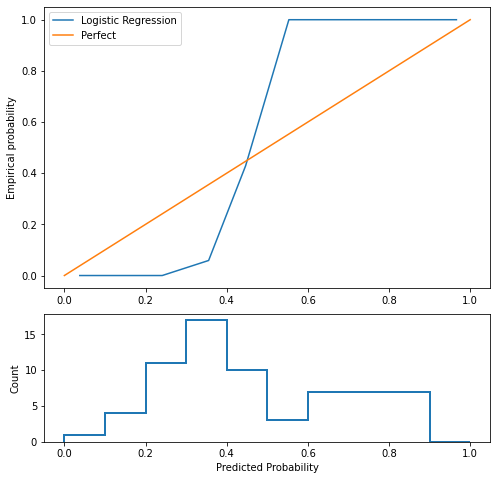

In [14]:
import pandas as pd 
x_train, x_test, y_train, y_test = train_test_split(xA, yA, test_size=0.33, random_state=2020)
y_train=np.where(y_train==-1.,0,1)
main(x_train, y_train, x_test, y_test)

Given the reliability plot it seems like our GLM assumptions do not hold. Since not all ranges $(a,b) \subset [0,1]$ are calibrated.

It is also worth mentioning that if you take the mean of the score distribution, it should ideally be close to the prior.

In [15]:
# prior
print(len(y_train[y_train==1])/len(y_train))

# mean of score distribution
# print(probs.mean())

0.4626865671641791


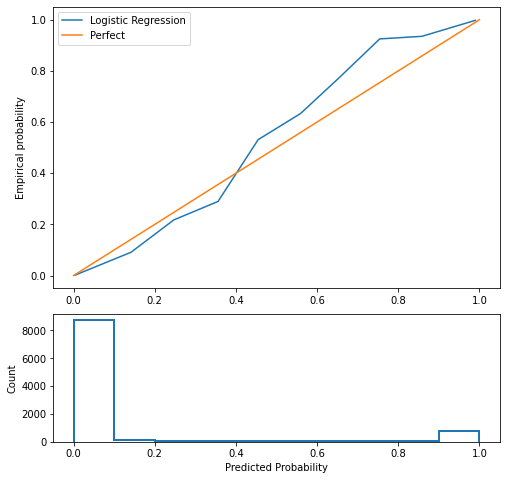

In [16]:
# Let's use the MNIST dataset, which is bigger
data_train=np.genfromtxt('./code/mnist_train.csv', delimiter=',')
# data_test=np.genfromtxt('./code/mnist_test.csv', delimiter=',')
x_train=data_train[:,1:data_train.shape[1]]
x_train = preprocessing.scale(x_train)
y_train=data_train[:,0]
y_train=np.where(y_train==3,1,0)
main(x_train, y_train)

In [17]:
# prior
print(len(y_train[y_train==1])/len(y_train))

# mean of score distribution
# print(probs.mean())

0.101


## (a)

__Show that the above property holds true for the described logistic regression model over the range $(a, b) = (0, 1)$.
Hint: Use the fact that we include a bias term.__

## (b)

__If we have a binary classification model that is perfectly calibrated—that is, the property we just proved holds for any $(a, b) \subset [0, 1]$ — does this necessarily imply that the model achieves perfect accuracy? Is the converse necessarily true? Justify your answers.__

## (c)

__Discuss what effect including L2 regularization in the logistic regression objective has on model calibration.__

# Bayesian Interpretation of Regularization

## (a)

__Show that $\theta_{MAP} = \text{argmax}_{\theta} p(y|x, \theta)p(\theta)$ if we assume that $p(\theta)=p(\theta|x)$. The assumption that $p(\theta)=p(\theta|x)$ will be valid for models such as linear regression where the input $x$ are not explicitly modeled by $\theta$. (Note that this means $x$ and $\theta$ are marginally independent, but not conditionally independent when $y$ is given.)__




We have thhe function $p(\theta|x,y),$ which by Bayes Theorem is equivalent to 

$$p(\theta|x,y)=\frac{p(x,y|\theta)p(\theta)}{p(x,y)}$$

In terms of the optimization problem we can treat the denominator as a constant and so:

$\text{argmax}_{\theta}p(x,y|\theta)p(\theta)$

$=\text{argmax}_{\theta}p(y|x,\theta)p(x|\theta)p(\theta)$

$=\text{argmax}_{\theta}p(y|x,\theta)p(x)p(\theta)$

$=\text{argmax}_{\theta}p(y|x,\theta)p(\theta)$

## (b)

__Recall that L2 regularization penalizes the L2 norm of the parameters while minimizing the loss (i.e., negative log likelihood in case of probabilistic models). Now we will show that MAP estimation with a zero-mean Gaussian prior over $\theta$, specifically $\theta$ ∼ $N(0,\eta^2I)$, is equivalent to applying L2 regularization with MLE estimation. Specifically, show that:__

$$\theta_{MAP}=\text{argmin}_{\theta}-\text{log}p(y|x,\theta)+\lambda||\theta||^2$$

**Also, what is the value of $\lambda$?**

$\text{argmax}_{\theta}p(y|x,\theta)p(\theta)$

$=\text{argmax}_{\theta}\text{log}p(y|x,\theta) + \text{log}p(\theta)$

Note that: 

$p(\theta)=\frac{1}{\sqrt{2\pi}|\eta I|^n}e^{-\theta^T\frac{1}{2\eta^2}\theta}$

$\implies \text{log}p(\theta)=\text{log}\frac{1}{\sqrt{2\pi}|\eta I|^n}-\theta^T\frac{1}{2\eta^2}\theta$

$\implies \text{log}p(\theta)=\text{log}\frac{1}{\sqrt{2\pi}|\eta I|^n}-\frac{1}{2\eta^2}||\theta||^2$

And so:

$\text{argmax}_{\theta}\text{log}p(y|x,\theta) + \text{log}p(\theta)$

$=\text{argmax}_{\theta}\text{log}p(y|x,\theta) -\frac{1}{2\eta^2}||\theta||^2$

$=\text{argmin}_{\theta}-\text{log}p(y|x,\theta) +\frac{1}{2\eta^2}||\theta||^2$

And so $\lambda = \frac{1}{2\eta^2}.$


## (c)

__Now consider a specific instance, a linear regression model given by $y = \theta^Tx + \epsilon$ where $\epsilon \sim N(0,\sigma^2)$. Like before, assume a Gaussian prior on this model such that $\theta ∼ N(0,\eta^2I)$. For notation, let $X$ be the design matrix of all the training example inputs where each row vector is one example input, and $y$ be the column vector of all the example outputs. Come up with a closed form expression for $\theta_{MAP}$.__

If $\epsilon \sim N(0,\sigma^2)$ then $y = \theta^Tx + \epsilon \sim N(\theta^Tx,\sigma^2)$

$p(y|x, \theta)=\displaystyle \prod_{i=1}^{N}\frac{1}{\sqrt{2\pi}\sigma}e^{\frac{(y_i-\theta^Tx^{(i)})(y_i-\theta^Tx^{(i)})}{2\sigma^2}}$

$\text{log}p(y|x, \theta)=-N\text{log}(\sqrt{2\pi}\sigma)-\frac{1}{2\sigma^2}\displaystyle \sum_{i=1}^{N}(y_i-\theta^Tx^{(i)})(y_i-\theta^Tx^{(i)})$

And so,

$\theta_{MAP}=\text{argmin}_{\theta}-\text{log}p(y|x,\theta) +\frac{1}{2\eta^2}||\theta||^2$

$=\text{argmin}_{\theta}\frac{1}{2\sigma^2}\displaystyle \sum_{i=1}^{N}(y_i-\theta^Tx^{(i)})(y_i-\theta^Tx^{(i)})+\frac{1}{2\eta^2}||\theta||^2$

$=\text{argmin}_{\theta}\frac{1}{\sigma^2}\displaystyle \sum_{i=1}^{N}(y_i-\theta^Tx^{(i)})(y_i-\theta^Tx^{(i)})+\frac{1}{\eta^2}||\theta||^2$

$=\text{argmin}_{\theta}\frac{1}{\sigma^2}||y-X\theta||^2+\frac{1}{\eta^2}||\theta||^2$

This is a quadratic function of $\theta.$

$=\text{argmin}_{\theta}\frac{1}{\sigma^2}(y^Ty-2y^TX\theta+\theta^TX^TX\theta)+\frac{1}{\eta^2}\theta^T\theta$

Let us find the gradient of the quadratic function of $\theta.$

$\nabla_{\theta}(\frac{1}{\sigma^2}(y^Ty-2y^TX\theta+\theta^TX^TX\theta)+\frac{1}{\eta^2}\theta^T\theta)$

$=\frac{2}{\sigma^2}(-X^Ty+X^TX\theta)+\frac{2}{\eta^2}\theta$

Setting the gradient equal to $0.$

$\frac{1}{\sigma^2}(-X^Ty+X^TX\theta)+\frac{1}{\eta^2}\theta=0$

$\implies \theta=(X^TX+\frac{\sigma^2}{\eta^2}I)^{-1}X^Ty$

Since the hessian of the function of $\theta$ is positive semi-definite, the above result is clearly a minimum.

## (d)

**Next, consider the Laplace distribution, whose density is given by**

$f_{L}(z|\mu,b)= \frac{1}{2b} e^{−\frac{|z−\mu|􏰄}{b}}.$

__As before, consider a linear regression model given by $y = x^T \theta + \epsilon$ where $\epsilon \sim N(0, \sigma^2)$. Assume a Laplace prior on this model where $\theta \sim L(0, bI)$.
Show that $\theta_{MAP}$ in this case is equivalent to the solution of linear regression with L1 regularization, whose loss is specified as:__ 

$J(\theta) = ||X\theta −y||^2 + \gamma||\theta||_1$

**Also, what is the value of $\gamma$?**

Let us consider $p(\theta).$

$p(\theta)=\frac{1}{2b} e^{−\frac{||\theta|􏰄|_1}{b}}$

$\implies \text{log}p(\theta)=-\text{log}2b −\frac{||\theta|􏰄|_1}{b}$

And so we have that $\gamma = \frac{1}{b}$

# Constructing Kernels

Let $K_1, K_2$ be kernels over $R^n \times R^n$, let $a \in R_+$ be a positive real number, let $f : R^n 􏰀\to R$ be a real-valued function, let $\phi:R^n\to R^d$ be a function mapping from $R^n$ to $R^d$, let $K_3$ be a kernel over $R^d \times R^d$, and let $p(x)$ a polynomial over $x$ with positive coefficients.

For each of the functions K below, state whether it is necessarily a kernel. If you think it is, prove it; if you think it isn’t, give a counter-example.

# Kernelizing the Perceptron

1. $K(x, z) = K_1(x, z)+K_2(x, z)$

Yes, because the sum of two symmetric positive semi-definite matrices is symmetric positive semi-definite: $y^T(K_1(x, z) + K_2(x, z))y=y^TK_1(x, z)y + y^TK_2(x, z)y \geq 0~~\forall y \in R^n$


2. $K(x, z) = K_1(x, z) − K_2(x, z)$

No. Consider $K_1(x, z)=I$ and $K_2(x, z)=2I.$ Then $K(x, z)$ is symmetric negative semi-definite and cannot be a kernel.

3. $K(x, z) = aK_1(x, z)$

Yes, reasoning same as 1.

4. $K(x, z) = −aK1(x, z)$

No, reasoning same as 2.

5. $K(x, z) = K_1(x, z)K_2(x, z)$
6. $K(x,z) = f(x)f(z)$
7. $K(x, z) = K_3(\phi(x), \phi(z))$
8. $K(x, z) = p(K_1(x, z))$

__Without kernelizing we would have__,


$\theta \leftarrow 0$ // initializing weight vector

$\forall (x^{(i)}, y_i):$

$\hat{y_i} \leftarrow \theta^T\phi(x^{(i)})$

$\theta \leftarrow \theta + \alpha(y_i-\hat{y_i})\phi(x^{(i)})$

__Kernelizing we would have,__

$a \leftarrow 0$ // initializing coefficient vector

$\forall (x^{(i)}, y_i):$

$\hat{y_i} \leftarrow \displaystyle \sum_{m=1}^{i-1}a_m(\phi(x^{(m)})^T\phi(x^{(i)}))= \displaystyle \sum_{m=1}^{i-1}a_mK(x^{(m)},x^{(i)})$

$a_i \leftarrow a_i + \alpha(y_i-\hat{y_i})$

where $K$ can be any valid kernel matrix (think gaussian, polynomial, etc.)

In [ ]:
import sys
sys.path.insert(0, './code/')

import util
import p05_percept

# Let's visualize our training data
x, y = util.load_csv('./data/ds5_train.csv')

In [ ]:
plt.scatter(x[y==0,0], x[y==0,1], marker='x', c='green', label='Label 0')
plt.scatter(x[y==1,0], x[y==1,1], marker='o', c='purple', label='Label 1')
plt.legend()
plt.title("Training Data")

Note that there are various models you could consider other than kernelized perceptron: kernelized logistic regression, SVM, ..., etc.

In [ ]:
p05_percept.main('./data/ds5_train.csv', './data/ds5_test.csv')